In [1]:
%load_ext aiida
%aiida

Loaded AiiDA DB environment - profile name: presto.

In [1]:
import matplotlib.pyplot as plt
from aiida.plugins import DataFactory, WorkflowFactory
from aiida import orm
from aiida.engine import submit
import json
import numpy as np

from aiida_common_workflows.common import ElectronicType, RelaxType, SpinType
from aiida_common_workflows.plugins import get_entry_point_name_from_class
from aiida_common_workflows.plugins import load_workflow_entry_point

In [3]:
q = QueryBuilder().append(
    orm.StructureData, filters={'and': [{'extras.element': 'Fe'}, {'extras.configuration': 'X/BCC'}]}, project=['*', 'extras']
).all()
q

[[<StructureData: uuid: ed04f989-9fd3-4d93-8070-9587ab083b9c (pk: 935)>,
  {'Z': 26, 'element': 'Fe', 'configuration': 'X/BCC'}]]

In [18]:
PLUGIN_NAME = 'quantum_espresso'


if PLUGIN_NAME == 'quantum_espresso':
    CODE_LABEL = 'qe-7.3-gf-pw@thor'
    engine_options = {
        'code': CODE_LABEL,
        'options': {
            'resources': {
                'num_machines': 1,
                'num_mpiprocs_per_machine': 48
            },
            'queue_name': 'lms',
            'max_wallclock_seconds': 1 * 3600,
        }
    }
    
    sub_process_overrides = {  # optional code-dependent overrides
        'clean_workdir': orm.Bool(True),
        'base': {
            'pw': {
                'settings' : orm.Dict(dict= {
                    'cmdline': ['-nk', '8'],
                })
            }
        },
        'base_final_scf': {
            'pw': {
                'settings' : orm.Dict(dict= {
                    'cmdline': ['-nk', '8'],
                })
            }
        },
    }

In [5]:
scale_factors = np.round(
    np.concatenate(
        [
            np.arange(0.4, 0.5, 0.04),
            np.arange(0.5, 0.64, 0.01),
            np.arange(0.64, 1.1, 0.04),
            np.arange(1.1, 1.3, 0.01),
            np.arange(1.3, 1.65, 0.04),
        ]
    ), 3
).tolist()

In [6]:
len(scale_factors)

59

In [7]:
# json_scheme = {
#     'scale_factors': scale_factors,
#     'volumes A^3': [s.get_cell_volume() for s in load_node(600968).outputs.structures.values()],
#     'energies eV/atom': [None] * len(scale_factors),
#     'total_magnetization mu_B / atom': [None] * len(scale_factors),
# }

In [8]:
# with open('fe_bcc_magnetization_vs_volume.json', 'w') as f:
#     json.dump(json_scheme, f, indent=4)

In [9]:
sub_process_overrides

{'clean_workdir': <Bool: uuid: 0c0b5d53-6073-4f29-8a07-afd10f6c06be (unstored) value: True>,
 'base': {'pw': {'settings': <Dict: uuid: 0d7a0ebd-a6a9-476d-9371-a2bc0f364557 (unstored)>}},
 'base_final_scf': {'pw': {'settings': <Dict: uuid: 23757b72-c0bc-401d-a5ef-3ccdf745d2b8 (unstored)>}}}

In [10]:
query_pseudos = QueryBuilder().append(Group, filters={'label': 'jason_magnetization_tests'}, tag='group').append(
    Node, with_group='group', filters={'attributes.process_label': 'MagnetizationChangeWorkChain'}, tag='mag_wc'
).append(
    Node, with_outgoing='mag_wc', project=['id', 'attributes'], edge_filters={'label': 'pseudo'},
    filters={'attributes.element': 'Fe'}
)

# .append(
#     Node, with_incoming='mag_wc', filters={'attributes.process_label': 'MagnetizationWorkChain'}, tag='mag'
# ).append(
#     Node, with_outgoing='mag', project='*'
# )

In [11]:
pseudo_mapping = {
    d[1]['filename']: d[0] for d in query_pseudos.all()
}

In [12]:
pseudo_mapping

{'Fe.paw.pbe.z_16.ld1.psl.v0.2.1.upf': 359504,
 'Fe.us.pbe.z_16.uspp.gbrv.v1.5.upf': 359110,
 'Fe.paw.pbe.z_16.atompaw.jth.v1.1-std.upf': 359675,
 'Fe.nc.pbe.z_16.oncvpsp4.spms.v1.upf': 359631,
 'Fe.nc.pbe.z_16.oncvpsp3.dojo.v0.4.1-str.upf': 359908,
 'Fe.us.pbe.z_16.ld1.psl.v1.0.0-high.upf': 359738,
 'Fe.paw.pbe.z_8.ld1.psl.v1.0.0-low.upf': 373141,
 'Fe.paw.pbe.z_16.ld1.psl.v1.0.0-high.upf': 359367,
 'Fe.nc.pbe.z_16.oncvpsp4.sg15.v0.upf': 359530,
 'Fe.nc.pbe.z_16.oncvpsp3.dojo.v0.4.1-std.upf': 359903,
 'Fe.us.pbe.z_16.ld1.psl.v0.2.1.upf': 373469,
 'Fe.us.pbe.z_8.ld1.psl.v1.0.0-low.upf': 373368}

In [19]:
sub_process_overrides

{'clean_workdir': <Bool: uuid: 0aef2270-77f5-43ae-ad1c-91defdfc31e9 (unstored) value: True>,
 'base': {'pw': {'settings': <Dict: uuid: 10674663-26d1-40ad-903f-473bf04686f4 (unstored)>}},
 'base_final_scf': {'pw': {'settings': <Dict: uuid: ae74a23f-3ea9-4b37-b1d5-9262b5da491e (unstored)>}}}

In [20]:
# sub_process_overrides['base']['pw']['pseudos'] = {'Fe': load_node(359675)}
# sub_process_overrides['base_final_scf']['pw']['pseudos'] = {'Fe': load_node(359675)}

sub_process_overrides['base']['pw']['pseudos'] = {'Fe': load_node(359110)}
sub_process_overrides['base_final_scf']['pw']['pseudos'] = {'Fe': load_node(359110)}

In [21]:
eos_wc = WorkflowFactory('common_workflows.eos')

structure = load_node(935) # BCC Fe

sub_process_cls = load_workflow_entry_point('relax', PLUGIN_NAME)
sub_process_cls_name = get_entry_point_name_from_class(sub_process_cls).name
generator = sub_process_cls.get_input_generator()

engine_types = generator.spec().inputs['engines']
engines = {}
# There should be only one
for engine in engine_types:
    engines[engine] = engine_options

inputs = {
    'structure': structure,
    # 'scale_factors': List(scale_factors),
    'generator_inputs': {  # code-agnostic inputs for the relaxation
        'engines': engines,
        'protocol': 'verification-PBE-v1',
        'relax_type': RelaxType.NONE,
        'electronic_type': ElectronicType.METAL,
        'spin_type': SpinType.NONE,
        # 'magnetization_per_site': [3]
    },
    'sub_process_class': sub_process_cls_name,
    'sub_process' : sub_process_overrides
}


In [22]:
submit(eos_wc, **inputs)

<WorkChainNode: uuid: 597caca8-7a7a-4012-bdaa-2f5c0dc85511 (pk: 680467) (aiida.workflows:common_workflows.eos)>

## Periodic table of max magnetization - prepare json

In [57]:
mag_eos_wcs = QueryBuilder().append(
    Group, filters={'label': 'acwf-verification/unaries/workflows/quantum_espresso_magnetism_test'}, tag='group'
).append(
    Node, with_group='group', filters={'attributes.process_label': 'EquationOfStateWorkChain'}, tag='eos_wc'
).all(flat=True)

In [55]:
max([f.value for f in mag_eos_wcs[0][0].outputs.total_magnetizations.values()])

0.0

In [56]:
mag_eos_wcs[0][0].extras

/tmp/ipykernel_2747778/3676260756.py:1: AiidaDeprecationWarning: `WorkChainNode.extras` is deprecated, use `WorkChainNode.base.extras.all` instead. (this will be removed in v3)
  mag_eos_wcs[0][0].extras


{'element': 'Ag',
 '_aiida_hash': 'cb46dbce0b772057d3b531d08ea94095be0a8c9deed4f539501024e769b0579b',
 'configuration': 'X/FCC'}

In [72]:
mag_eos_wc_max_mag = {}
for w in mag_eos_wcs:
    if not w.is_finished_ok:
        continue
    label = f"{w.base.extras.all['element']}-{w.base.extras.all['configuration']}"
    mag_eos_wc_max_mag[label] = max([abs(f.value) for f in w.outputs.total_magnetizations.values()]) / len(w.inputs.structure.sites)

In [73]:
with open('QE_max_magnetization_per_atom.json', 'w') as f:
    json.dump(mag_eos_wc_max_mag, f, indent=4)

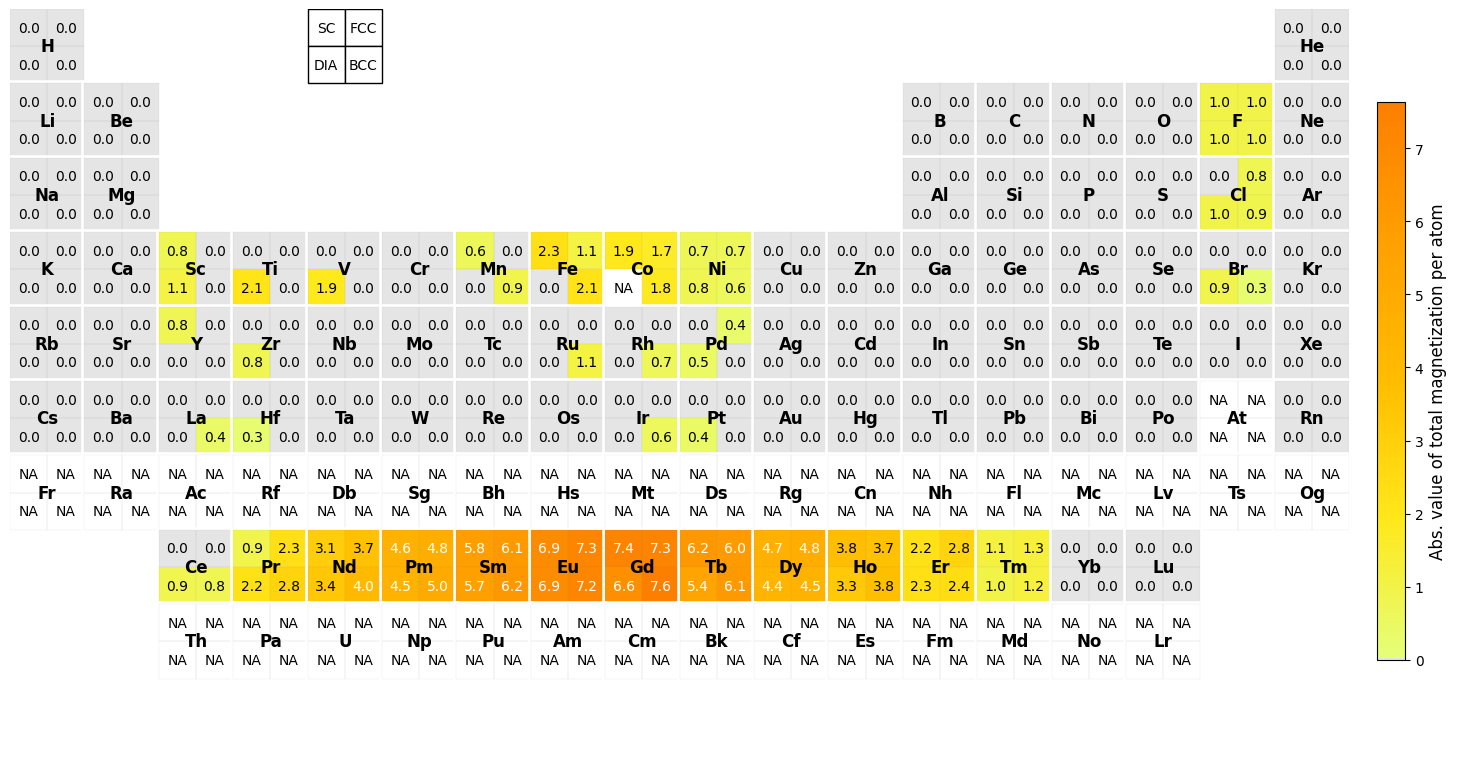

In [110]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Data dictionary with structure: "Element-X/Subfield": value
data = mag_eos_wc_max_mag

# Periodic table positions and element symbols
periodic_table = [
    (1, 1, "H"), (1, 18, "He"),
    (2, 1, "Li"), (2, 2, "Be"), (2, 13, "B"), (2, 14, "C"), (2, 15, "N"), (2, 16, "O"), (2, 17, "F"), (2, 18, "Ne"),
    (3, 1, "Na"), (3, 2, "Mg"), (3, 13, "Al"), (3, 14, "Si"), (3, 15, "P"), (3, 16, "S"), (3, 17, "Cl"), (3, 18, "Ar"),
    (4, 1, "K"), (4, 2, "Ca"), (4, 3, "Sc"), (4, 4, "Ti"), (4, 5, "V"), (4, 6, "Cr"), (4, 7, "Mn"), (4, 8, "Fe"),
    (4, 9, "Co"), (4, 10, "Ni"), (4, 11, "Cu"), (4, 12, "Zn"), (4, 13, "Ga"), (4, 14, "Ge"), (4, 15, "As"), (4, 16, "Se"),
    (4, 17, "Br"), (4, 18, "Kr"),
    (5, 1, "Rb"), (5, 2, "Sr"), (5, 3, "Y"), (5, 4, "Zr"), (5, 5, "Nb"), (5, 6, "Mo"), (5, 7, "Tc"), (5, 8, "Ru"),
    (5, 9, "Rh"), (5, 10, "Pd"), (5, 11, "Ag"), (5, 12, "Cd"), (5, 13, "In"), (5, 14, "Sn"), (5, 15, "Sb"), (5, 16, "Te"),
    (5, 17, "I"), (5, 18, "Xe"),
    (6, 1, "Cs"), (6, 2, "Ba"), (6, 3, "La"), (6, 4, "Hf"), (6, 5, "Ta"), (6, 6, "W"), (6, 7, "Re"), (6, 8, "Os"),
    (6, 9, "Ir"), (6, 10, "Pt"), (6, 11, "Au"), (6, 12, "Hg"), (6, 13, "Tl"), (6, 14, "Pb"), (6, 15, "Bi"), (6, 16, "Po"),
    (6, 17, "At"), (6, 18, "Rn"),
    (7, 1, "Fr"), (7, 2, "Ra"), (7, 3, "Ac"), (7, 4, "Rf"), (7, 5, "Db"), (7, 6, "Sg"), (7, 7, "Bh"), (7, 8, "Hs"),
    (7, 9, "Mt"), (7, 10, "Ds"), (7, 11, "Rg"), (7, 12, "Cn"), (7, 13, "Nh"), (7, 14, "Fl"), (7, 15, "Mc"), (7, 16, "Lv"),
    (7, 17, "Ts"), (7, 18, "Og"),
    (8, 3, "Ce"), (8, 4, "Pr"), (8, 5, "Nd"), (8, 6, "Pm"), (8, 7, "Sm"), (8, 8, "Eu"), (8, 9, "Gd"), (8, 10, "Tb"),
    (8, 11, "Dy"), (8, 12, "Ho"), (8, 13, "Er"), (8, 14, "Tm"), (8, 15, "Yb"), (8, 16, "Lu"),
    (9, 3, "Th"), (9, 4, "Pa"), (9, 5, "U"), (9, 6, "Np"), (9, 7, "Pu"), (9, 8, "Am"), (9, 9, "Cm"), (9, 10, "Bk"),
    (9, 11, "Cf"), (9, 12, "Es"), (9, 13, "Fm"), (9, 14, "Md"), (9, 15, "No"), (9, 16, "Lr")
]

# Extract values for each element and subfields (BCC, Diamond, SC)
def get_values(symbol):
    subfields = ["SC", "FCC", "Diamond", "BCC"]
    return [data.get(f"{symbol}-X/{subfield}", 'NA') for subfield in subfields]

# Create a color map for the values
cmap = plt.get_cmap("Wistia")
norm = plt.Normalize(vmin=min(data.values()), vmax=max(data.values()))
# Customize the colormap to set the value 0 to green

# Create a new colormap that sets 0 to green
colors = [(cmap(norm(v)) if v != 0. else (.5, .5, .5, .2)) for v in np.linspace(norm.vmin, norm.vmax, cmap.N)]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=cmap.N)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 12))
ax.set_xlim(0.5, 18.5)
ax.set_ylim(0.5, 10.5)
ax.set_aspect("equal")
ax.axis("off")

# Function to draw an element cell
def draw_element(ax, row, col, symbol, values, cmap):
    x, y = col, 11 - row  # Adjust y to plot from top to bottom
    width, height = 1, 1

    # Main cell
    rect = patches.Rectangle((x - 0.5, y - 0.5), width, height, linewidth=4, edgecolor='white', facecolor='white')
    ax.add_patch(rect)

    # Subfields (split into 3 parts)
    sub_width, sub_height = width / 2, height / 2
    sub_positions = [
        (x - 0.5, y - 0.5 + sub_height),  # Top-left (BCC)
        (x - 0.5 + sub_width, y - 0.5 + sub_height),  # Top-right (Diamond)
        (x - 0.5, y - 0.5),  # Bottom-left (SC)
        (x - 0.5 + sub_width, y - 0.5),  # Bottom-right (FCC)
    ]

    for (sx, sy), value in zip(sub_positions, values):
        color = cmap(norm(value)) if value != 'NA' else (0, 0, 0, 0)
        sub_rect = patches.Rectangle((sx, sy), sub_width, sub_height, linewidth=.05, edgecolor='grey', facecolor=color)
        ax.add_patch(sub_rect)
        val_to_show = f"{value:.1f}" if value != 'NA' else 'NA'
        ax.text(sx + sub_width / 2, sy + sub_height / 2, val_to_show,
                ha='center', va='center', fontsize=10, color='white' if value != 'NA' and norm(value) > 0.5 else 'black')

    # Element symbol
    ax.text(x, y, symbol, ha='center', va='center', fontsize=12, weight='bold', color='black')

# Draw each element
for row, col, symbol in periodic_table:
    values = get_values(symbol)
    draw_element(ax, row, col, symbol, values, custom_cmap)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', fraction=0.02, pad=0.02, ax=ax)
cbar.set_label('Abs. value of total magnetization per atom', fontsize=12)

x = 5
y = 10
sub_width, sub_height = 1 / 2, 1 / 2
rect = patches.Rectangle((x - 0.5, y - 0.5), 1, 1, linewidth=4, edgecolor='white', facecolor='white')
sub_positions = [
    (x - 0.5, y - 0.5 + sub_height),  # Top-left (BCC)
    (x - 0.5 + sub_width, y - 0.5 + sub_height),  # Top-right (Diamond)
    (x - 0.5, y - 0.5),  # Bottom-left (SC)
    (x - 0.5 + sub_width, y - 0.5),  # Bottom-right (FCC)
]
for (sx, sy), v in zip(sub_positions, ["SC", "FCC", "DIA", "BCC"]):
    sub_rect = patches.Rectangle((sx, sy), sub_width, sub_height, linewidth=1, edgecolor='black', facecolor='white')
    ax.add_patch(sub_rect)
    ax.text(sx + sub_width / 2, sy + sub_height / 2, f"{v}", 
            ha='center', va='center', fontsize=10, color='black')


plt.show()


In [15]:
wc = load_node(600968)

In [24]:
process_label = 'PwRelaxWorkChain'

In [2]:
with open('jason_vol_magnetization/for-timo/2024-11-megnatization/fe_mag_vol.json', 'r') as f:
    ref_data = json.load(f)

with open('/home/reents_t/project/aiida-cwf/git/AE-verification-data/magnetism/wien2k_fe_bcc_magnetization_vs_volume.json', 'r') as f:
    wien2k_ae_ref_data = json.load(f)
    
with open('git/AE-verification-data/magnetism/mag-results-BCC-Fe-PBE-fleur.json', 'r') as f:
    fleur_ref_data = json.load(f)

wien2k_ae_ref_data.keys()

dict_keys(['scale_factors', 'volumes A^3', 'energies eV/atom', 'total_magnetization mu_B / atom'])

In [127]:
import numpy as np

echarge = 1.60217733e-19

def BM(energies):

    fitdata = np.polyfit(energies[:,0]**(-2./3.), energies[:,1], 3, full=True)
    ssr = fitdata[1]
    sst = np.sum((energies[:,1] - np.average(energies[:,1]))**2.)
    residuals0 = ssr/sst
    deriv0 = np.poly1d(fitdata[0])
    deriv1 = np.polyder(deriv0, 1)
    deriv2 = np.polyder(deriv1, 1)
    deriv3 = np.polyder(deriv2, 1)

    volume0 = 0
    x = 0
    for x in np.roots(deriv1):
        # Last check: it's real, no imaginary part
        if x > 0 and deriv2(x) > 0 and abs(x.imag) < 1.e-8:
            volume0 = x**(-3./2.)
            break

    if volume0 == 0:
        raise ValueError('Error: No minimum could be found')

    # Get also the E0 and return it
    E0 = deriv0(x)

    derivV2 = 4./9. * x**5. * deriv2(x)
    derivV3 = (-20./9. * x**(13./2.) * deriv2(x) -
        8./27. * x**(15./2.) * deriv3(x))
    bulk_modulus0 = derivV2 / x**(3./2.)
    bulk_deriv0 = -1 - x**(-3./2.) * derivV3 / derivV2

    return volume0, E0, bulk_modulus0, bulk_deriv0, residuals0

def birch_murnaghan(V,E0,V0,B0,B01):
    """
    Return the energy for given volume (V - it can be a vector) according to
    the Birch Murnaghan function with parameters E0,V0,B0,B01.
    """
    r = (V0/V)**(2./3.)
    return (E0 +
            9./16. * B0 * V0 * (
            (r-1.)**3 * B01 + 
            (r-1.)**2 * (6. - 4.* r)))

def get_eos_data(node):
    volumes = []
    energies = []

    for i, strct in node.outputs.structures.items():
        vol = strct.get_cell_volume()
        en = node.outputs.total_energies[i].value
        
        volumes.append(vol)
        energies.append(en)

    energies = [e for _, e in sorted(zip(volumes, energies))]
    volumes = sorted(volumes)
    # List as I need to JSON-serialize it
    eos_data = (np.array([volumes, energies]).T).tolist()
    
    return eos_data

def get_data_to_plot(node, e_min_to_0=False, vol_min_to_0=False):
    if isinstance(node, dict):
        if 'volumes A^3' in node:
            volumes = node['volumes A^3']
            energies = node['energies eV/atom']
            eos_data = np.array([volumes, energies]).T
    elif isinstance(node, list):
        eos_data = np.array(node)
    else:
        eos_data = get_eos_data(node)
        volumes, energies = zip(*eos_data)
        energies = np.array(energies)
        eos_data = np.array(eos_data)
    
    min_volume, E0, bulk_modulus_internal, bulk_deriv, residuals = BM(eos_data)
    eos = {
        'V0': min_volume,
        'B0': bulk_modulus_internal,
        'B01': bulk_deriv,
    }
    
    print(min_volume)
    volumes = eos_data[:,0]
    energies = eos_data[:,1]
    dense_volumes = np.linspace(
        min(volumes),
        max(volumes),
        300
    )
    bulk_modulus_GPa = bulk_modulus_internal * echarge * 1.0e21
    bulk_modulus_ev_ang3 = bulk_modulus_GPa / 160.21766208

    dense_energies = birch_murnaghan(
        V=dense_volumes,
        E0=E0,
        V0=min_volume,
        B0=bulk_modulus_ev_ang3,
        B01=bulk_deriv
    )

    if e_min_to_0:
        energies -= dense_energies.min()
        dense_energies -= dense_energies.min()
    if vol_min_to_0:
        print(dense_volumes[dense_energies.argmin()])
        volumes -= dense_volumes[dense_energies.argmin()]
        dense_volumes -= dense_volumes[dense_energies.argmin()]

    return volumes, energies, dense_volumes, dense_energies, eos

In [27]:
def scale(x, norm):
    if norm is None:
        return x
    return (np.array(x) - norm) / norm * 100

In [28]:
init_volume = 11.533519654912876 # taken from wien2k #11.38236 # structure.get_cell_volume()
init_volume_nm = structure.get_cell_volume()

def get_volumes_magnetization(wc, v_norm=None):


    volumes = []
    total_magnetizations = []

    if wc.is_finished_ok:
        relax_wcs = [
            node for node in wc.called_descendants if node.process_label == process_label
        ]
        for relax_wc in relax_wcs:
            volume = relax_wc.inputs.structure.get_cell_volume()
            total_magnetization = relax_wc.outputs.output_parameters.get_dict()['total_magnetization']
            
            volumes.append(volume)
            total_magnetizations.append(total_magnetization)

    volumes = np.array(volumes)
    if v_norm is not None:
        volumes = (volumes - v_norm) / v_norm * 100
    # volumes = (volumes - init_volume_nm) / init_volume_nm * 100
    # volumes = (volumes - init_volume) / init_volume * 
    
    return volumes, total_magnetizations

In [29]:
qe_sssp_volumes, qe_sssp_tm = get_volumes_magnetization(load_node(600968), v_norm=init_volume)
qe_gbrv_volumes, qe_gbrv_tm = get_volumes_magnetization(load_node(631670), v_norm=init_volume)
qe_jth_volumes, qe_jth_tm = get_volumes_magnetization(load_node(631722), v_norm=init_volume)

In [3]:
with open('/home/reents_t/project/aiida-cwf/git/acwf-verification-scripts_tests/acwf_paper_plots/code-data/results-unaries-verification-PBE-v1-AE-average.json', 'r') as f:
    nm_ae_average0 = json.load(f)
    
with open('/home/reents_t/project/aiida-cwf/git/acwf-verification-scripts_tests/acwf_paper_plots/code-data/results-unaries-verification-PBE-v1-wien2k-dk_0.06.json', 'r') as f:
    nm_ae_wien2k= json.load(f)

In [5]:
nm_ae_wien2k.keys()

dict_keys(['BM_fit_data', 'completely_off', 'eos_data', 'failed_wfs', 'missing_outputs', 'num_atoms_in_sim_cell', 'script_version', 'set_name', 'stress_data', 'uuid_mapping'])

In [115]:
nm_fe_bcc_ae_average = {}

for k, v in nm_ae_average0['BM_fit_data']['Fe-X/BCC'].items():
    if k == 'bulk_modulus_ev_ang3':
        nm_fe_bcc_ae_average['B0'] = v
    elif k == 'bulk_deriv':
        nm_fe_bcc_ae_average['B01'] = v
    elif k == 'min_volume':
        nm_fe_bcc_ae_average['V0'] = v
        

In [119]:
nm_ae_average0.keys()

dict_keys(['BM_fit_data', 'num_atoms_in_sim_cell', 'script_version'])

In [123]:
nm_ae_wien2k_data = nm_ae_wien2k['eos_data']['Fe-X/BCC']

In [145]:

wien2k_vol, wien2k_en, wien2k_dense_vol, wien2k_dense_en, wien2k_eos = get_data_to_plot(wien2k_ae_ref_data, e_min_to_0=True, vol_min_to_0=False)
fleur_vol, fleur_en, fleur_dense_vol, fleur_dense_en, fleur_eos = get_data_to_plot(fleur_ref_data, e_min_to_0=True, vol_min_to_0=False)


qe_sssp_vol, qe_sssp_en, qe_sssp_dense_vol, qe_sssp_dense_en, qe_sssp_eos = get_data_to_plot(load_node(600968), e_min_to_0=True, vol_min_to_0=False)
qe_gbrv_vol, qe_gbrv_en, qe_gbrv_dense_vol, qe_gbrv_dense_en, qe_gbrv_eos = get_data_to_plot(load_node(631670), e_min_to_0=True, vol_min_to_0=False)
qe_jth_vol, qe_jth_en, qe_jth_dense_vol, qe_jth_dense_en, qe_jth_eos = get_data_to_plot(load_node(631722), e_min_to_0=True, vol_min_to_0=False)


ae_average_nm_vol, ae_average_nm_en, ae_average_nm_dense_vol, ae_average_nm_dense_en, ae_average_nm_eos = get_data_to_plot(nm_ae_wien2k_data, e_min_to_0=True, vol_min_to_0=False)
qe_jth_vol_nm, qe_jth_en_nm, qe_jth_dense_vol_nm, qe_jth_dense_en_nm, qe_jth_eos_nm = get_data_to_plot(load_node(680296), e_min_to_0=True, vol_min_to_0=False)
qe_gbrv_vol_nm, qe_gbrv_en_nm, qe_gbrv_dense_vol_nm, qe_gbrv_dense_en_nm, qe_gbrv_eos_nm = get_data_to_plot(load_node(680467), e_min_to_0=True, vol_min_to_0=False)

11.533519654912876
11.531579477509457
11.564152976673444
11.598230070872479
11.65438859079834
10.501277782740472
10.607822290205485
10.4964965333472


In [144]:
[s.get_cell_volume() for s in load_node(680296).outputs.structures.values()]

[9.876039918656506,
 10.086168427564939,
 10.296296936471306,
 10.506425445379893,
 10.716553954287987,
 10.926682463195744,
 11.136810972102065]

In [134]:
ae_average_nm_vol

array([ 9.87604243, 10.08616754, 10.29629995, 10.50642325, 10.71655618,
       10.92668017, 11.13681194])

In [147]:
qe_jth_vol_nm

array([ 9.87603992, 10.08616843, 10.29629694, 10.50642545, 10.71655395,
       10.92668246, 11.13681097])

In [41]:
nm_fe_bcc_ae_average, qe_jth_eos, qe_gbrv_eos, qe_jth_eos_nm

({'B01': 4.614369803082259,
  'B0': 1.6735508470915752,
  'V0': 10.500484196384424},
 {'V0': 11.65438859079834, 'B0': 1.1267718973232779, 'B01': 4.416286058971132},
 {'V0': 11.598230070872479, 'B0': 1.113651515743529, 'B01': 4.413376450225091},
 {'V0': 10.607822290205485,
  'B0': 1.6558314795293017,
  'B01': 4.578023973983568})

In [43]:
import acwf_paper_plots.quantities_for_comparison as qc
from itertools import combinations, product
import pandas as pd
import seaborn as sns

In [154]:
eos_mapping = {
    # 'WIEN2k': wien2k_eos,
    # 'FLEUR': fleur_eos,
    # 'QE@PBE_SSSP_1.3': qe_sssp_eos,
    # 'QE@GBRV-1.X': qe_gbrv_eos,
    # 'QE@JTH-1.1-std': qe_jth_eos,
    'AE_avg': nm_fe_bcc_ae_average,
    'QE@JTH-1.1-std-nm': qe_jth_eos_nm,
    'QE@GBRV-1.X-nm': qe_gbrv_eos_nm,
}

DEFAULT_wb0 = 1.0/20.0
DEFAULT_wb1 = 1.0/400.0

eos_compare_eps = {}
eos_compare_nu = {}


for comb in product(eos_mapping.keys(), eos_mapping.keys()):
    epsilon = qc.epsilon(
        eos_mapping[comb[0]]['V0'], eos_mapping[comb[0]]['B0'], eos_mapping[comb[0]]['B01'],
        eos_mapping[comb[1]]['V0'], eos_mapping[comb[1]]['B0'], eos_mapping[comb[1]]['B01'],
        1, DEFAULT_wb0, DEFAULT_wb1
    )
    
    nu = qc.nu(
        eos_mapping[comb[0]]['V0'], eos_mapping[comb[0]]['B0'], eos_mapping[comb[0]]['B01'],
        eos_mapping[comb[1]]['V0'], eos_mapping[comb[1]]['B0'], eos_mapping[comb[1]]['B01'],
        100, DEFAULT_wb0, DEFAULT_wb1
    )
    
    print(f'{comb[0]} vs {comb[1]}: {epsilon}')
    eos_compare_eps.setdefault(comb[0], {})[comb[1]] = epsilon
    eos_compare_nu.setdefault(comb[0], {})[comb[1]] = nu
    

AE_avg vs AE_avg: 0.0005623778078984932
AE_avg vs QE@JTH-1.1-std-nm: 0.6193851097221393
AE_avg vs QE@GBRV-1.X-nm: 0.023927784325556044
QE@JTH-1.1-std-nm vs AE_avg: 0.6193371240325145
QE@JTH-1.1-std-nm vs QE@JTH-1.1-std-nm: 0.00037533602270609946
QE@JTH-1.1-std-nm vs QE@GBRV-1.X-nm: 0.6399545828510002
QE@GBRV-1.X-nm vs AE_avg: 0.023927177474371557
QE@GBRV-1.X-nm vs QE@JTH-1.1-std-nm: 0.6400128543433532
QE@GBRV-1.X-nm vs QE@GBRV-1.X-nm: 0.0002664510565188487


<Axes: >

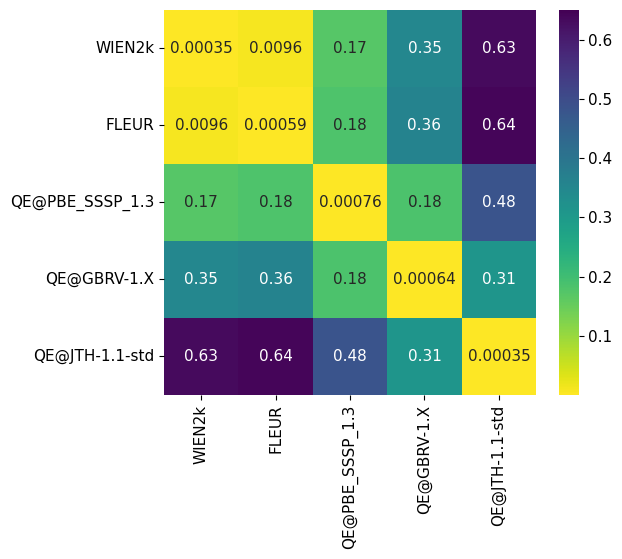

In [57]:
plt.figure(figsize=(6, 5))

eos_comp_eps_df = pd.DataFrame(eos_compare_eps)

sns.heatmap(eos_comp_eps_df, annot=True, cmap='viridis_r', vmax=0.65)

<Axes: >

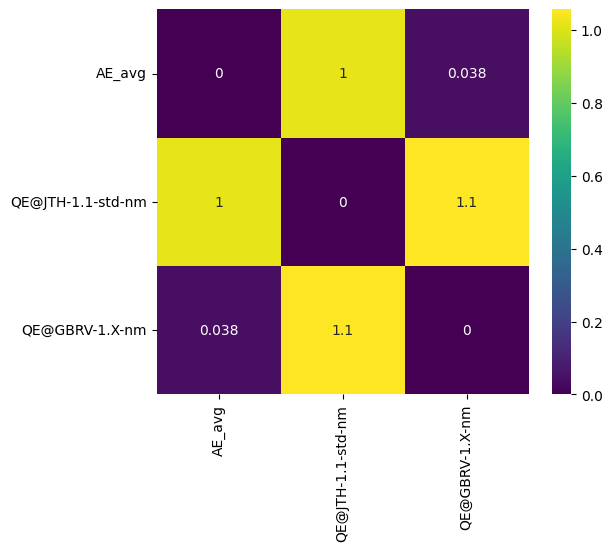

In [155]:
plt.figure(figsize=(6, 5))

eos_comp_nu_df = pd.DataFrame(eos_compare_nu)

sns.heatmap(eos_comp_nu_df, annot=True, cmap='viridis')

In [113]:
eos_comp_nu_df['NM_AE_avg']

WIEN2k                9.563336
FLEUR                 9.545981
QE@PBE_SSSP_1.3       9.823762
QE@GBRV-1.X          10.135991
QE@JTH-1.1-std       10.598134
NM_AE_avg             0.000000
QE@JTH-1.1-std-nm     1.018416
QE@GBRV-1.X-nm        0.038096
Name: NM_AE_avg, dtype: float64

In [28]:
plt.rcParams['font.size'] = 11

[Text(0, -5.0, ''),
 Text(0, 0.0, ''),
 Text(0, 5.0, ''),
 Text(0, 10.0, ''),
 Text(0, 15.0, ''),
 Text(0, 20.0, '')]

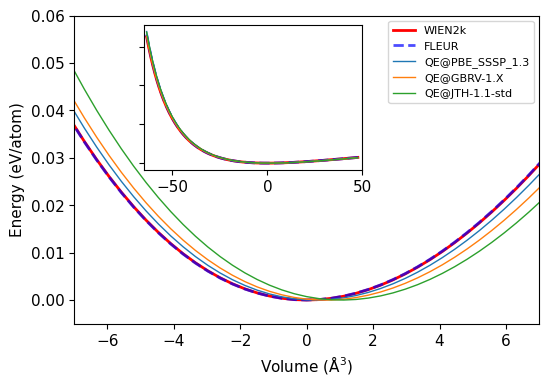

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(scale(wien2k_dense_vol, init_volume), wien2k_dense_en, label='WIEN2k', color='red', linestyle='-', linewidth=2)
ax.plot(scale(fleur_dense_vol, init_volume), fleur_dense_en, label='FLEUR', color='blue', linestyle='--', linewidth=2, alpha=0.7)

ax.plot(scale(qe_sssp_dense_vol, init_volume), qe_sssp_dense_en, label='QE@PBE_SSSP_1.3',# color='red', 
        linestyle='-', linewidth=1)
ax.plot(scale(qe_gbrv_dense_vol, init_volume), qe_gbrv_dense_en, label='QE@GBRV-1.X',# color='green',
        linestyle='-', linewidth=1)
ax.plot(scale(qe_jth_dense_vol, init_volume), qe_jth_dense_en, label='QE@JTH-1.1-std',# color='orange', 
        linestyle='-', linewidth=1)

ax.legend(fontsize=8)
ax.set_xlabel('Volume (Å$^3$)')
ax.set_ylabel('Energy (eV/atom)')
ax.set_xlim(-7, 7)
ax.set_ylim(-0.005, 0.06)

# Add inset showing the full range
ax_inset = ax.inset_axes([0.15, 0.5, 0.47, 0.47])
ax_inset.plot(scale(wien2k_dense_vol, init_volume), wien2k_dense_en, label='WIEN2k', color='red', linestyle='-', linewidth=2)
ax_inset.plot(scale(fleur_dense_vol, init_volume), fleur_dense_en, label='FLEUR', color='blue', linestyle='--', linewidth=2, alpha=0.7)
ax_inset.plot(scale(qe_sssp_dense_vol, init_volume), qe_sssp_dense_en, label='QE@PBE_SSSP_1.3', linestyle='-', linewidth=1)
ax_inset.plot(scale(qe_gbrv_dense_vol, init_volume), qe_gbrv_dense_en, label='QE@GBRV-1.X', linestyle='-', linewidth=1)
ax_inset.plot(scale(qe_jth_dense_vol, init_volume), qe_jth_dense_en, label='QE@JTH-1.1-std', linestyle='-', linewidth=1)
ax_inset.set_xlim(-65, 50)
# ax_inset.set_ylim(-0.01, 0.07)
# ax_inset.set_xticklabels([])
ax_inset.set_yticklabels([])

(-0.005, 0.06)

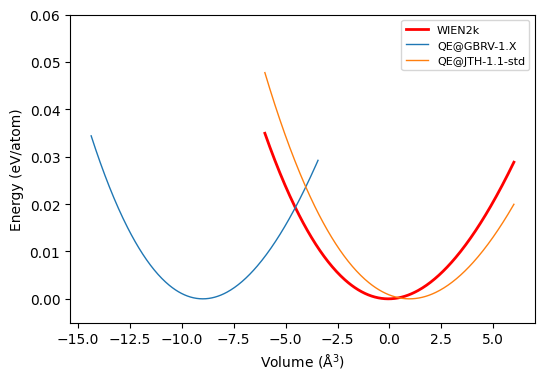

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(scale(ae_average_nm_dense_vol, init_volume_nm), ae_average_nm_dense_en, label='WIEN2k', color='red', linestyle='-', linewidth=2)
# ax.plot(scale(fleur_dense_vol, init_volume), fleur_dense_en, label='FLEUR', color='blue', linestyle='--', linewidth=2, alpha=0.7)

# ax.plot(scale(qe_sssp_dense_vol_n, init_volume), qe_sssp_dense_en, label='QE@PBE_SSSP_1.3',# color='red', 
#         linestyle='-', linewidth=1)
ax.plot(scale(qe_gbrv_dense_vol_nm, init_volume), qe_gbrv_dense_en_nm, label='QE@GBRV-1.X',# color='green',
        linestyle='-', linewidth=1)
ax.plot(scale(qe_jth_dense_vol_nm, init_volume_nm), qe_jth_dense_en_nm, label='QE@JTH-1.1-std',# color='orange', 
        linestyle='-', linewidth=1)

ax.legend(fontsize=8)
ax.set_xlabel('Volume (Å$^3$)')
ax.set_ylabel('Energy (eV/atom)')
# ax.set_xlim(-7, 7)
ax.set_ylim(-0.005, 0.06)

(5.0, 20.0)

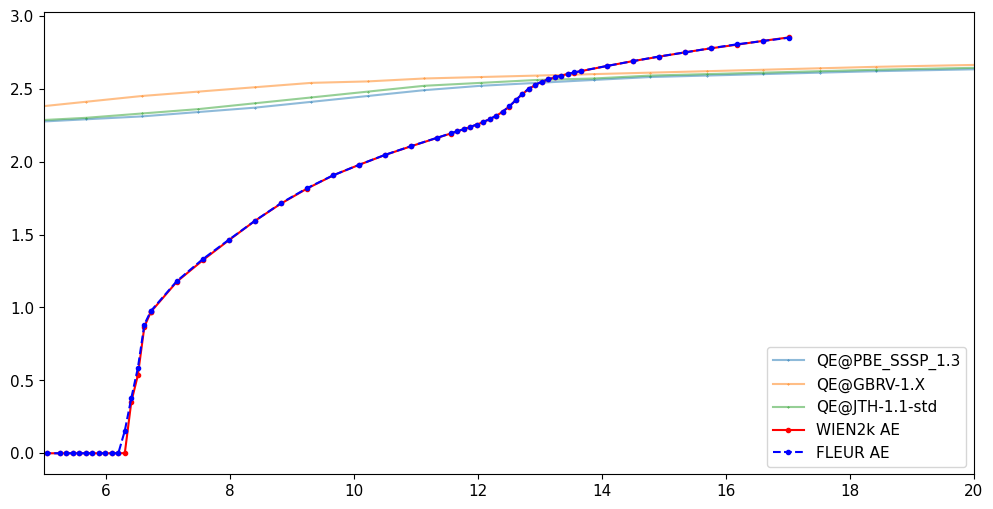

In [89]:
plt.figure(figsize=(12, 6))

# for lab, (x, y, c) in ref_data.items():
#     x = np.array(x)
#     plt.plot(x / 100 * init_volume + init_volume, y, label=lab, color=c, marker='o', markersize=1)

plt.plot(
    qe_sssp_volumes, qe_sssp_tm, label='QE@PBE_SSSP_1.3', #color='black', 
    marker='x', markersize=1, alpha=0.5)
plt.plot(
    qe_gbrv_volumes, qe_gbrv_tm, label='QE@GBRV-1.X', #color='black', 
    marker='x', markersize=1, alpha=0.5)
plt.plot(
    qe_jth_volumes, qe_jth_tm, label='QE@JTH-1.1-std', #color='black', 
    marker='x', markersize=1, alpha=0.5)

plt.plot(
    # (np.array(wien2k_ae_ref_data['volumes A^3']) - init_volume) / init_volume * 100,
    wien2k_ae_ref_data['volumes A^3'],
    wien2k_ae_ref_data['total_magnetization mu_B / atom'],
    label='WIEN2k AE',
    color='red',
    marker='o',
    markersize=3
)

plt.plot(
    # (np.array(fleur_ref_data['volumes A^3']) - init_volume) / init_volume * 100,
    fleur_ref_data['volumes A^3'],
    fleur_ref_data['total_magnetization mu_B / atom'],
    label='FLEUR AE',
    color='blue',
    marker='o',
    markersize=3,
    linestyle='--'
)

plt.legend()

plt.xlim(5, 20)

NameError: name 'volumes' is not defined

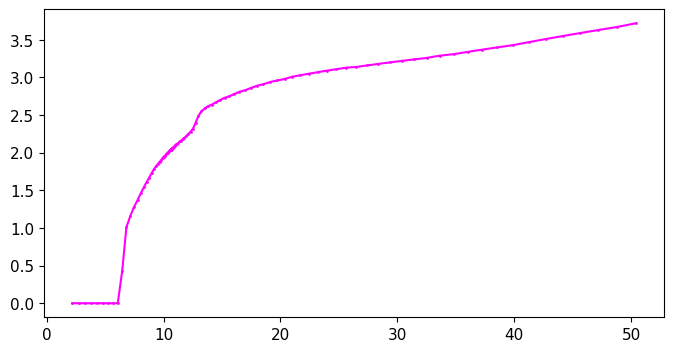

In [90]:
plt.figure(figsize=(8, 4))

for lab, (x, y, c) in ref_data.items():
    if lab != 'PSL-PAW-v0.x':
        continue
    x = np.array(x)
    plt.plot(x / 100 * init_volume + init_volume, y, label=lab, color=c, marker='o', markersize=1)

plt.plot(volumes, total_magnetizations, label='QE@PBE_SSSP_1.3', color='black', marker='x', markersize=1, alpha=0.5)
plt.plot(
    # (np.array(wien2k_ae_ref_data['volumes A^3']) - init_volume) / init_volume * 100,
    wien2k_ae_ref_data['volumes A^3'],
    wien2k_ae_ref_data['total_magnetization mu_B / atom'],
    label='WIEN2k AE',
    color='red',
    marker='o',
    markersize=3
)

# Add inset
ax_inset = plt.gca().inset_axes([0.5, 0.1, 0.47, 0.47])
for lab, (x, y, c) in ref_data.items():
    if lab != 'PSL-PAW-v0.x':
        continue
    x = np.array(x)
    ax_inset.plot(x / 100 * init_volume + init_volume, y, label=lab, color=c, marker='o', markersize=1)

ax_inset.plot(volumes, total_magnetizations, label='QE@PBE_SSSP_1.3', color='black', marker='x', markersize=1, alpha=0.5)
ax_inset.plot(
    wien2k_ae_ref_data['volumes A^3'],
    wien2k_ae_ref_data['total_magnetization mu_B / atom'],
    label='WIEN2k AE',
    color='red',
    marker='o',
    markersize=3
)

ax_inset.set_xlim(5, 7)
ax_inset.set_ylim(-0.1, 1)
ax_inset.set_xticklabels([])
ax_inset.set_yticklabels([])

plt.legend()
plt.xlabel('Volume ($\AA^3$)')
plt.ylabel('Total magnetization ($\mu_B$)')

plt.xlim(5, 17)
plt.ylim(-0.1, 2.7)
plt.savefig('/home/reents_t/project/aiida-cwf/git/AE-verification-data/magnetism/fe_bcc_magnetization_vs_volume.png')

In [75]:
def tick_function(X, n=5):
    x0, x1 = X
    x_new = np.linspace(x0, x1, n)
    V = (x_new - init_volume) / init_volume * 100
    V = np.round(V, 1)
    return [z for z in V]

Text(0, 0.5, 'Total magnetization ($\\mu_B$)')

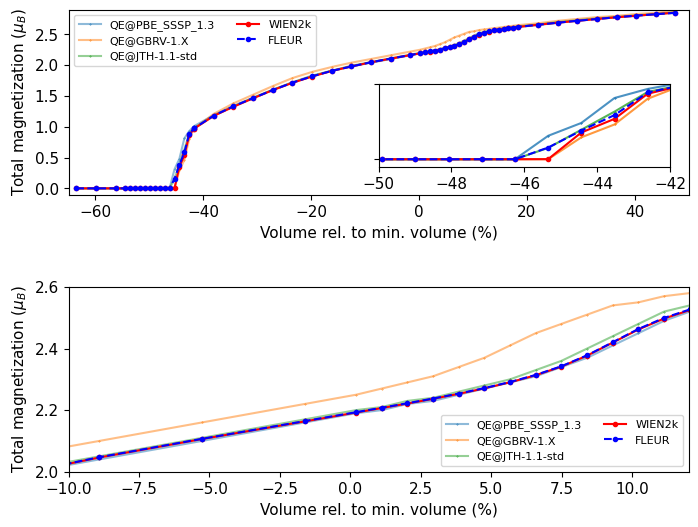

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plt.subplots_adjust(hspace=0.5)

# for lab, (x, y, c) in ref_data.items():
#     x = np.array(x)
#     plt.plot(x / 100 * init_volume + init_volume, y, label=lab, color=c, marker='o', markersize=1)

ax_ = ax[0]
ax_.plot(
    qe_sssp_volumes, qe_sssp_tm, label='QE@PBE_SSSP_1.3', #color='black', 
    marker='x', markersize=1, alpha=0.5)
ax_.plot(
    qe_gbrv_volumes, qe_gbrv_tm, label='QE@GBRV-1.X', #color='black', 
    marker='x', markersize=1, alpha=0.5)
ax_.plot(
    qe_jth_volumes, qe_jth_tm, label='QE@JTH-1.1-std', #color='black', 
    marker='x', markersize=1, alpha=0.5)

ax_.plot(
    # (np.array(wien2k_ae_ref_data['volumes A^3']) - init_volume) / init_volume * 100,
    scale(wien2k_ae_ref_data['volumes A^3'], init_volume),
    wien2k_ae_ref_data['total_magnetization mu_B / atom'],
    label='WIEN2k',
    color='red',
    marker='o',
    markersize=3
)

ax_.plot(
    # (np.array(fleur_ref_data['volumes A^3']) - init_volume) / init_volume * 100,
    scale(fleur_ref_data['volumes A^3'], init_volume),
    fleur_ref_data['total_magnetization mu_B / atom'],
    label='FLEUR',
    color='blue',
    marker='o',
    markersize=3,
    linestyle='--'
)

ax_.legend()

ax_.set_xlim(5, 20)
# Add inset
ax_inset = ax_.inset_axes([0.5, 0.15, 0.47, 0.45])

ax_inset.plot(
    qe_sssp_volumes, qe_sssp_tm, label='QE@PBE_SSSP_1.3', #color='black', 
    marker='x', markersize=1, alpha=0.8)
ax_inset.plot(
    qe_gbrv_volumes, qe_gbrv_tm, label='QE@GBRV-1.X', #color='black', 
    marker='x', markersize=1, alpha=0.8)
ax_inset.plot(
    qe_jth_volumes, qe_jth_tm, label='QE@JTH-1.1-std', #color='black', 
    marker='x', markersize=1, alpha=0.8)

ax_inset.plot(
    scale(wien2k_ae_ref_data['volumes A^3'], init_volume),
    wien2k_ae_ref_data['total_magnetization mu_B / atom'],
    label='WIEN2k',
    color='red',
    marker='o',
    markersize=3
)

ax_inset.plot(
    # (np.array(fleur_ref_data['volumes A^3']) - init_volume) / init_volume * 100,
    scale(fleur_ref_data['volumes A^3'], init_volume),
    fleur_ref_data['total_magnetization mu_B / atom'],
    label='FLEUR',
    color='blue',
    marker='o',
    markersize=3,
    linestyle='--'
)

ax_inset.set_xlim(-50, -42)
ax_inset.set_ylim(-0.1, 1)
# ax_inset.set_xticklabels([])
ax_inset.set_yticklabels([])
# ax_inset.yaxis.minorticks_on()

ax_.legend(ncols=2, loc='upper left', fontsize=8)
ax_.set_xlabel('Volume rel. to min. volume (%)')
ax_.set_ylabel('Total magnetization ($\mu_B$)')

ax_.set_xlim(-65, 50)
ax_.set_ylim(-0.1, 2.9)

# ax2 = ax_.twiny()
# ax2.xaxis.set_ticks_position('both')
# ax2.xaxis.set_label_position('top')

# ax2.set_xlim(ax_.get_xlim())
# new_ticks = tick_function(ax_.get_xlim())
# ax2.set_xticks(new_ticks)
# ax2.set_xticklabels(new_ticks)
# ax2.minorticks_on()





ax_ = ax[1]
ax_.plot(
    qe_sssp_volumes, qe_sssp_tm, label='QE@PBE_SSSP_1.3', #color='black', 
    marker='x', markersize=1, alpha=0.5)
ax_.plot(
    qe_gbrv_volumes, qe_gbrv_tm, label='QE@GBRV-1.X', #color='black', 
    marker='x', markersize=1, alpha=0.5)
ax_.plot(
    qe_jth_volumes, qe_jth_tm, label='QE@JTH-1.1-std', #color='black', 
    marker='x', markersize=1, alpha=0.5)

ax_.plot(
    # (np.array(wien2k_ae_ref_data['volumes A^3']) - init_volume) / init_volume * 100,
    scale(wien2k_ae_ref_data['volumes A^3'], init_volume),
    wien2k_ae_ref_data['total_magnetization mu_B / atom'],
    label='WIEN2k',
    color='red',
    marker='o',
    markersize=3
)

ax_.plot(
    # (np.array(fleur_ref_data['volumes A^3']) - init_volume) / init_volume * 100,
    scale(fleur_ref_data['volumes A^3'], init_volume),
    fleur_ref_data['total_magnetization mu_B / atom'],
    label='FLEUR',
    color='blue',
    marker='o',
    markersize=3,
    linestyle='--'
)

# ax2 = ax_.twiny()
# ax2.xaxis.set_ticks_position('both')
# ax2.xaxis.set_label_position('top')
ax_.set_xlim(-10, 12)

# ax2.set_xlim(ax_.get_xlim())
# new_ticks = tick_function(ax_.get_xlim())
# ax2.set_xticks(new_ticks)
# ax2.set_xticklabels(new_ticks)
# ax2.minorticks_on()

ax_.legend(ncols=2, loc='lower right', fontsize=8)

ax_.set_ylim(2, 2.6)
ax_.set_xlabel('Volume rel. to min. volume (%)')
ax_.set_ylabel('Total magnetization ($\mu_B$)')



# plt.savefig('/home/reents_t/project/aiida-cwf/git/AE-verification-data/magnetism/fe_bcc_magnetization_vs_volume.png')

In [93]:
ax_.get_xlim()

(-10.0, 12.0)

NameError: name 'volumes' is not defined

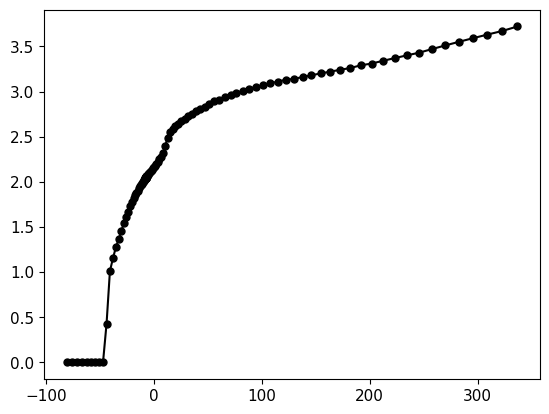

In [94]:
qe_ref = ref_data['PSL-PAW-v0.x']
plt.plot(
    np.array(qe_ref[0])# / 100 * init_volume + init_volume
    , qe_ref[1], label='Ref', color='black', marker='o', markersize=5)
plt.plot(
    volumes #/ 100 * init_volume + init_volume
    , total_magnetizations, label='QE@PBE_SSSP_1.3', color='blue', marker='x', markersize=8)
plt.plot(
    (np.array(wien2k_ae_ref_data['volumes A^3']) - init_volume) / init_volume * 100,
    wien2k_ae_ref_data['total_magnetization mu_B / atom'],
    label='WIEN2k AE',
    color='red',
    marker='o',
    markersize=3
)



plt.xlim(-3, 4)
# plt.xlim(-50, -30)
plt.xlim(2, 30)
# plt.xlim(5, 9)
# plt.ylim(-0.1, 3)
plt.legend()

Text(0, 0.5, 'Total magnetization ($\\mu_B$)')

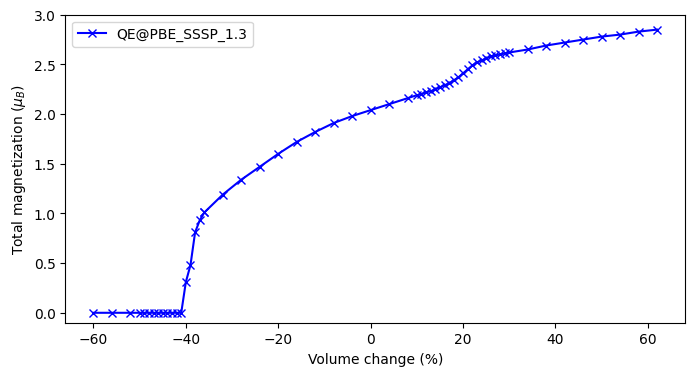

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(
    volumes #/ 100 * init_volume + init_volume
    , total_magnetizations, label='QE@PBE_SSSP_1.3', 
    color='blue', marker='x', markersize=6
    )
# plt.xlim(-3, 4)
# plt.xlim(2, 20)
# plt.xlim(5, 9)
plt.ylim(-0.1, 3)
plt.legend()
plt.xlabel('Volume change (%)')
plt.ylabel('Total magnetization ($\mu_B$)')

In [62]:
init_volume

10.506425445379893

In [59]:
load_node(587930).get_incoming().all_nodes()[0].get_dict()

/tmp/ipykernel_1823774/1088151063.py:1: AiidaDeprecationWarning: `CalcFunctionNode.get_incoming` is deprecated, use `CalcFunctionNode.base.links.get_incoming` instead. (this will be removed in v3)
  load_node(587930).get_incoming().all_nodes()[0].get_dict()


{'lsda': True,
 'energy': -2521.7994350132,
 'volume': 350.13751151613,
 'degauss': 0.06122561276385,
 'fft_grid': [192, 192, 192],
 'energy_xc': -565.65450840636,
 'wall_time': '  27m15.10s ',
 'rho_cutoff': 21769.10676048,
 'symmetries': [{'t_rev': '0', 'symmetry_number': 0},
  {'t_rev': '0', 'symmetry_number': 1},
  {'t_rev': '0', 'symmetry_number': 2},
  {'t_rev': '0', 'symmetry_number': 3},
  {'t_rev': '0', 'symmetry_number': 4},
  {'t_rev': '0', 'symmetry_number': 5},
  {'t_rev': '0', 'symmetry_number': 6},
  {'t_rev': '0', 'symmetry_number': 7},
  {'t_rev': '0', 'symmetry_number': 8},
  {'t_rev': '0', 'symmetry_number': 9},
  {'t_rev': '0', 'symmetry_number': 10},
  {'t_rev': '0', 'symmetry_number': 11},
  {'t_rev': '0', 'symmetry_number': 12},
  {'t_rev': '0', 'symmetry_number': 13},
  {'t_rev': '0', 'symmetry_number': 14},
  {'t_rev': '0', 'symmetry_number': 15},
  {'t_rev': '0', 'symmetry_number': 16},
  {'t_rev': '0', 'symmetry_number': 17},
  {'t_rev': '0', 'symmetry_number

In [61]:
load_node(587930).get_outgoing().all_nodes()[0].get_dict()

/tmp/ipykernel_1823774/3682324814.py:1: AiidaDeprecationWarning: `CalcFunctionNode.get_outgoing` is deprecated, use `CalcFunctionNode.base.links.get_outgoing` instead. (this will be removed in v3)
  load_node(587930).get_outgoing().all_nodes()[0].get_dict()


{'total_magnetization': 2.0, 'total_magnetization_units': 'Bohrmag / cell'}

In [54]:
load_node(588654).inputs.parameters.get_dict()

{'SYSTEM': {'nspin': 2,
  'degauss': 0.0045,
  'ecutrho': 1600,
  'ecutwfc': 100,
  'smearing': 'fd',
  'occupations': 'smearing',
  'starting_magnetization': {'Ni': 0.2}},
 'CONTROL': {'disk_io': 'nowf', 'tstress': True, 'calculation': 'scf'},
 'ELECTRONS': {'conv_thr': 1e-09, 'mixing_beta': 0.4}}